# Predicting the occupancies of Belgian trains

## 2. Exploratory Data Analysis


In [2]:
#vector/matrix library
import numpy as np
#data frame library (similar to R)
import pandas as pd

#visualization library
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#regular expression library for data cleasning
import re

In [3]:
dataset = pd.read_csv('json_cleaned.csv')
dataset.head(n=3)

,id,querytime,to,occupancy,from,train_series,train_direction,train_type
0,-1,2016-07-27 21:41:46,8822004,high,8812005,4500,away,IC
1,-1,2016-07-27 22:04:25,8831765,low,8831765,1500,back,IC
2,-1,2016-07-27 22:18:09,8813003,low,8831765,1500,back,IC


### 2.1 Occupancy Distribution

* Make a pie chart showing the distrubution of the class labels (occupancy). Are they uniformly distributed, and if not what does that imply for future model performance?

HINT: use value_counts() and the pandas plot function for pie charts



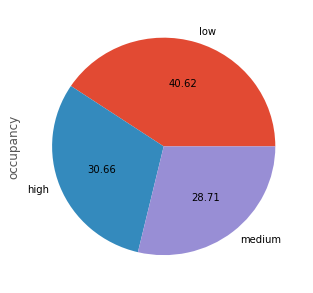

In [4]:
dataset['occupancy'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(5,5))

### 2.2 Vehicle Distribution

* Same exercice but now for train types

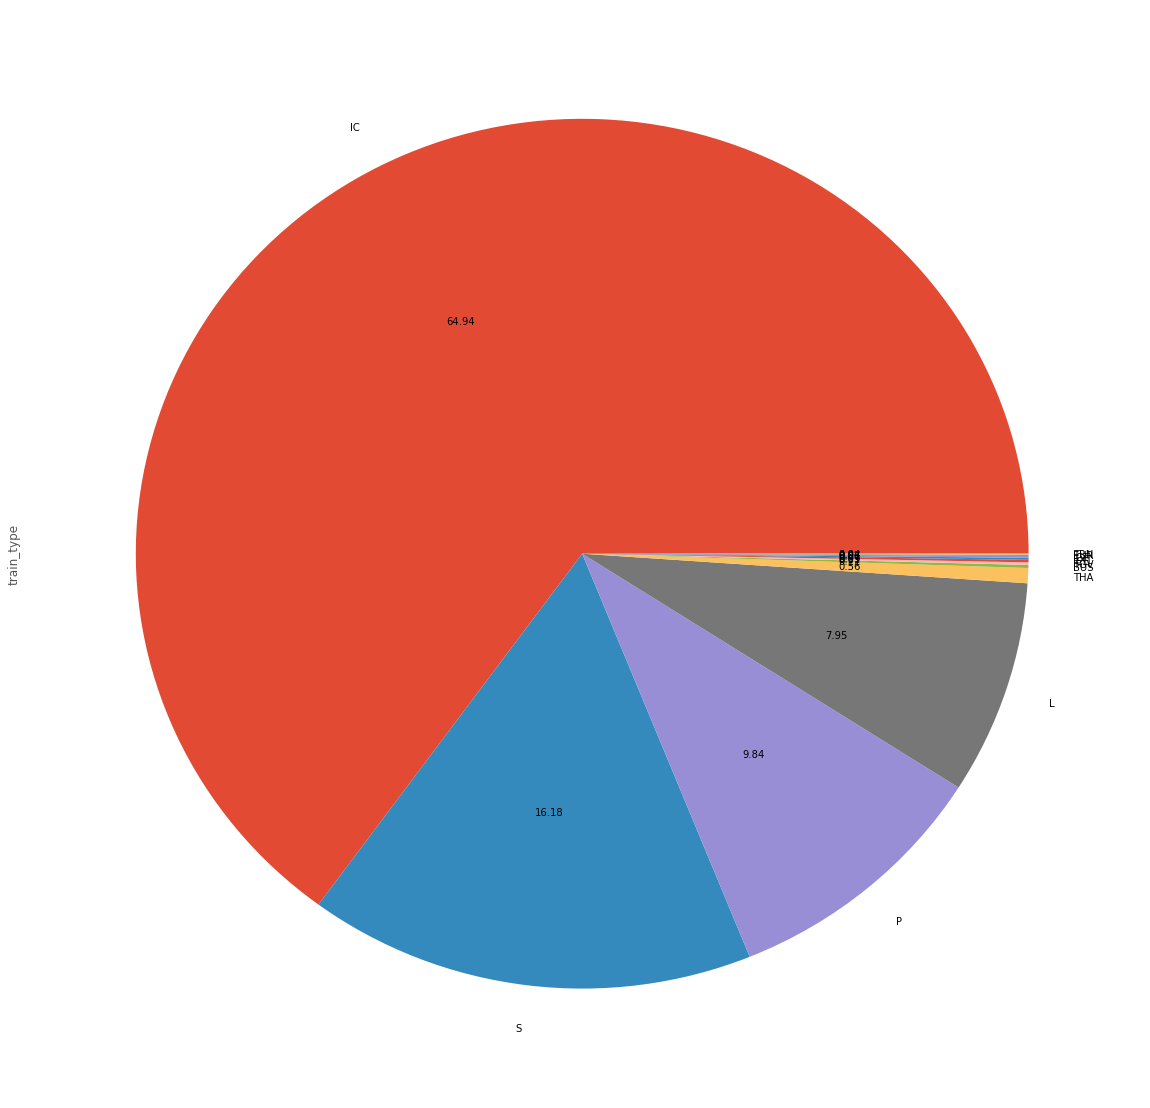

In [5]:
dataset['train_type'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(20,20))

## 2.3 Querytimes

1. Do query times between train and test set overlap?
2. Visualize the distribution of records over time (bar plots)
    * number of records per month
    * number of records per day => pay close attention, what does this chart teach you? 
    * number of records per weekday

HINT: pandas has plenty of support for time series operations. Have a look at the **resample** function, which allows you to aggregate over different time windows. It might be useful to override the current index with the query time values (a **datetime index** allows you to do time based slicing of the dataset)

In [6]:
#1
mask = dataset['id'] < 0

training_set = dataset[mask]
test_set = dataset[~mask]

print(training_set.shape[0])
print(test_set.shape[0])

4970
493


In [7]:
training_set['querytime'].describe()

count                    4970
unique                   4956
top       2016-10-29 08:59:55
freq                        2
Name: querytime, dtype: object

In [8]:
test_set['querytime'].describe()

count                     493
unique                    493
top       2017-03-09 06:35:04
freq                        1
Name: querytime, dtype: object

In [9]:
dataset.dtypes

id                  int64
querytime          object
to                  int64
occupancy          object
from                int64
train_series        int64
train_direction    object
train_type         object
dtype: object

In [10]:
#2a
dataset['querytime'] = pd.to_datetime(dataset['querytime'])
dataset_ind = dataset.set_index('querytime')

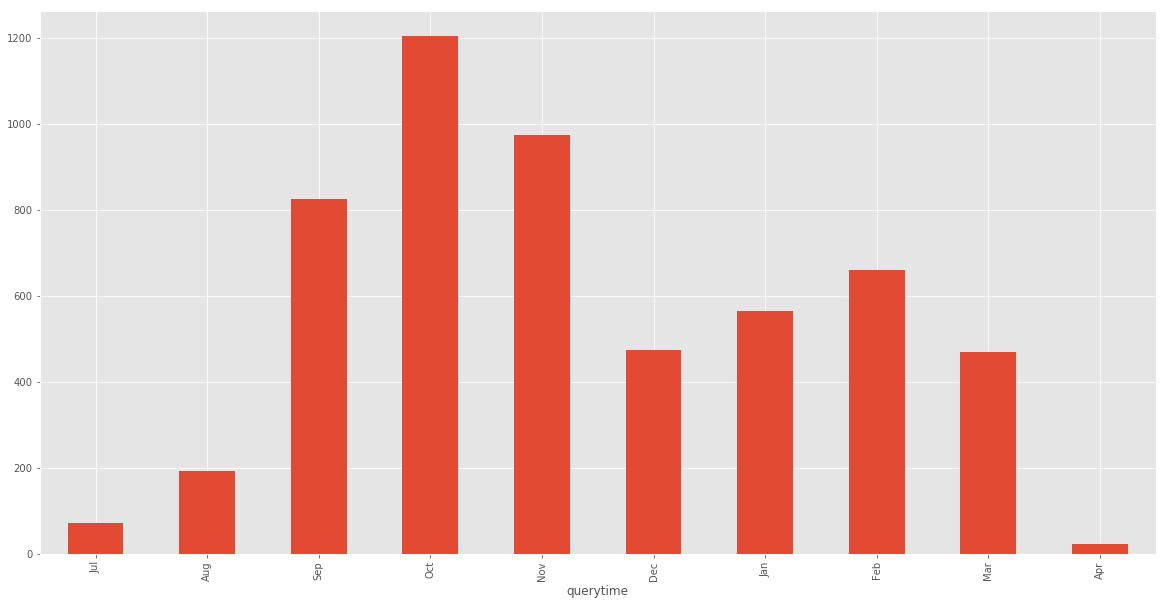

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

dataset_ind.resample('M').count()['id'].plot(kind='bar', ax=ax)
ax.set_xticklabels(['Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr'])

[]

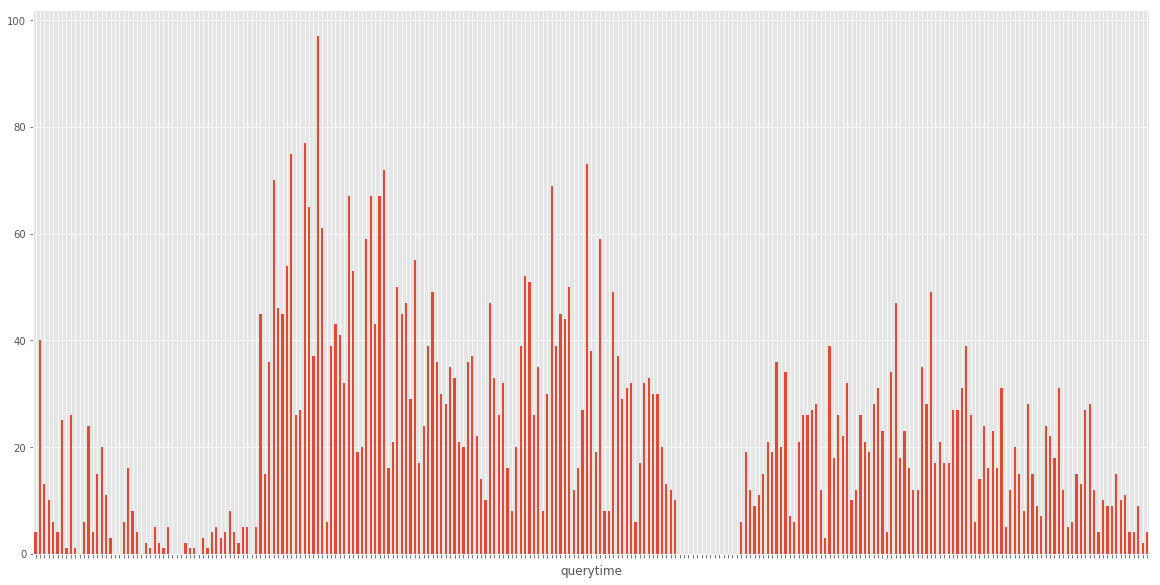

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

dataset_ind.resample('d').count()['id'].plot(kind='bar', ax=ax)
ax.set_xticklabels([])

In [ ]:
#2c
dataset['weekday'] = dataset['querytime'].apply(lambda d: d.weekday())
dataset.groupby('weekday').count().plot(kind='bar')


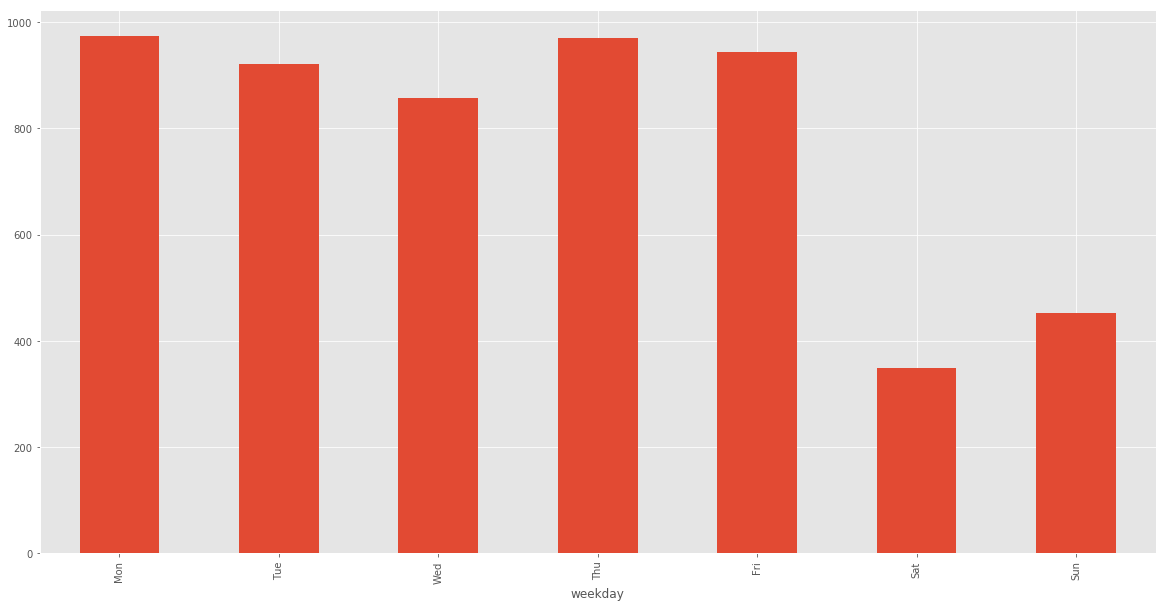

In [28]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

dataset.groupby('weekday').count()['id'].plot(kind='bar', ax=ax)

ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

## 2.4 Querytimes (one more)

1. Visualize the distribution over hour of the day => what are you seeing
2. Plot this distribution for saturdays and sundays as well
3. What happens if you create the previous plot for [start, October] and [November, end] (and plot only weekdays) => what do you think that is happening? How would you fix it => fix it in the first notebook!!

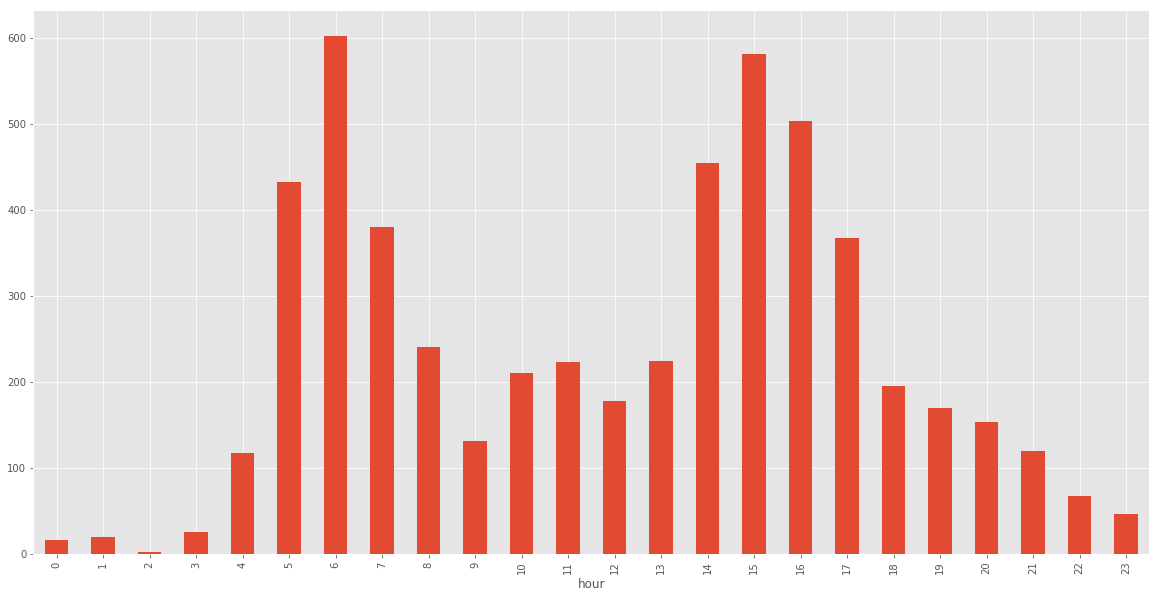

In [34]:
#1
dataset['hour'] = dataset['querytime'].apply(lambda d: d.hour)

fig, ax = plt.subplots(1,1, figsize=(20,10))

dataset.groupby('hour').count()['id'].plot(kind='bar', ax=ax)

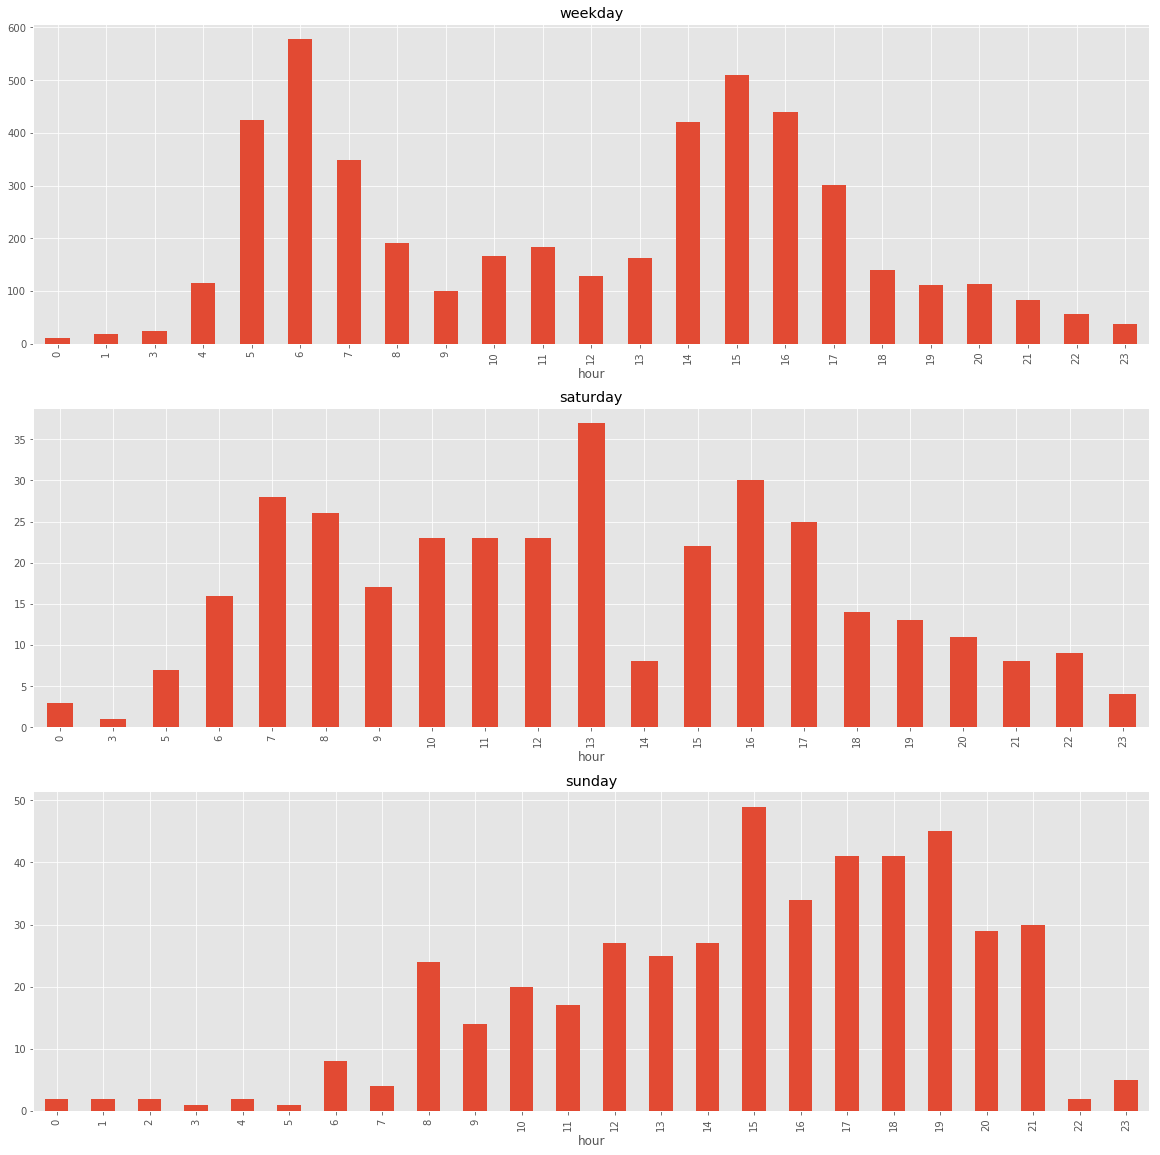

In [38]:
#2

#saturday
mask1= dataset['weekday'] < 5
mask2= dataset['weekday'] == 5
mask3= dataset['weekday'] == 6



fig, ax = plt.subplots(3,1, figsize=(20,20))

dataset[mask1].groupby('hour').count()['id'].plot(kind='bar', ax=ax[0], title='weekday')
dataset[mask2].groupby('hour').count()['id'].plot(kind='bar', ax=ax[1], title='saturday')
dataset[mask3].groupby('hour').count()['id'].plot(kind='bar', ax=ax[2], title='sunday')

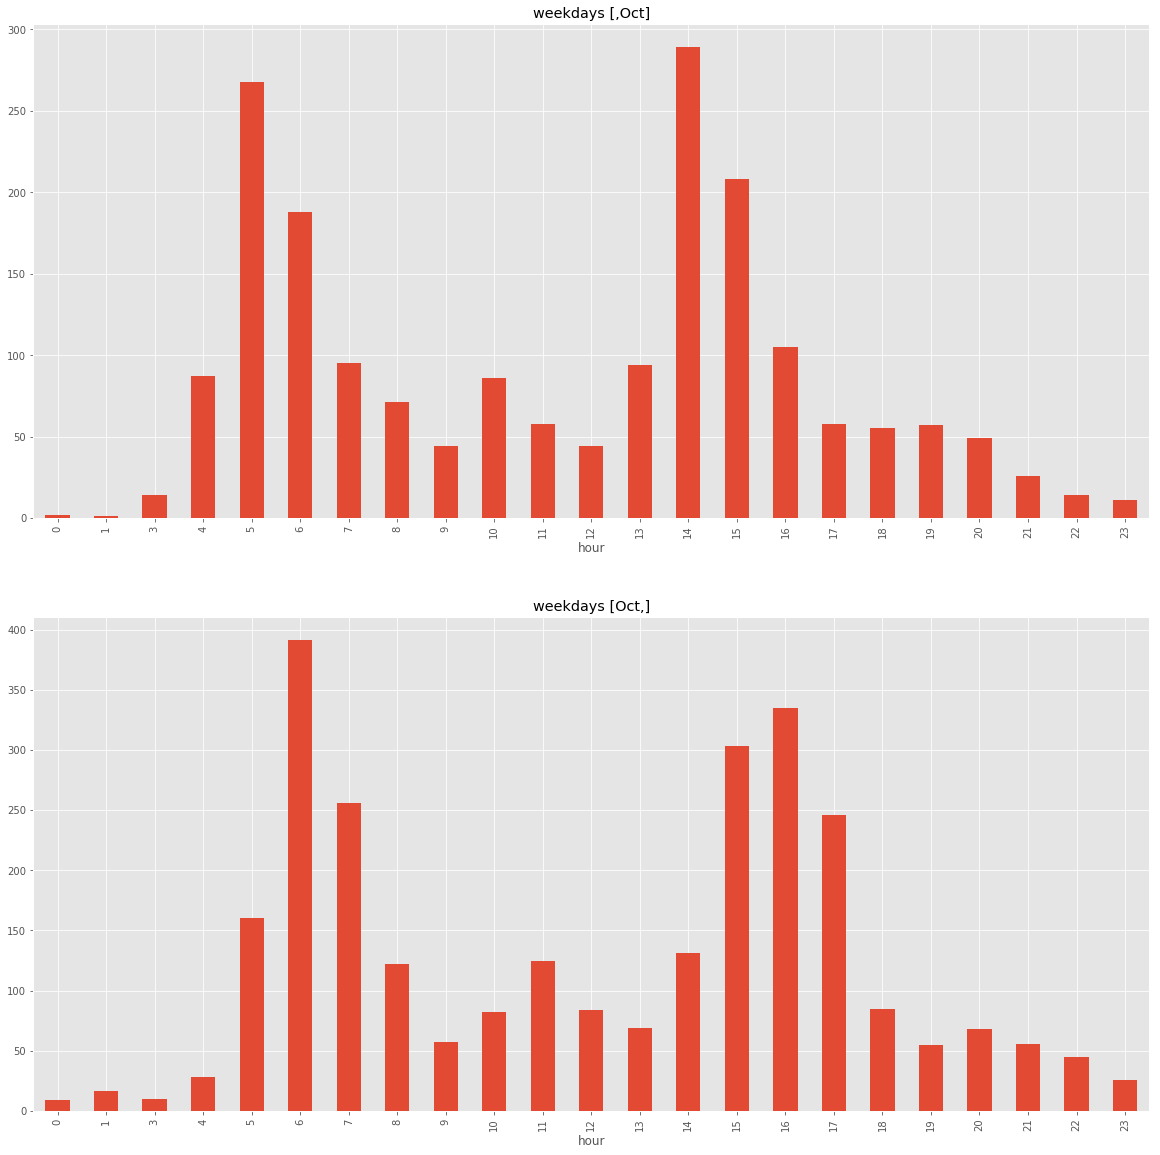

In [57]:
boundary = "20161031"

dataset_ind['querytime'] = dataset_ind.index
dataset_ind['weekday'] = dataset_ind['querytime'].apply(lambda d: d.weekday())
dataset_ind['hour'] = dataset_ind['querytime'].apply(lambda d: d.hour)

fig, ax = plt.subplots(2,1, figsize=(20,20))

dataset_weekdays = dataset_ind[dataset_ind['weekday'] < 5]

dataset_weekdays[:boundary].groupby('hour').count()['id'].plot(kind='bar', ax=ax[0], title='weekdays [,Oct]')
dataset_weekdays[boundary:].groupby('hour').count()['id'].plot(kind='bar', ax=ax[1], title='weekdays [Oct,]')


## 2.5 Occupancy dependence

1. How does the occupancy depend on the train type? (use a normalized stacked bar chart)
2. How does the occupancy vary per month
3. How does the occupancy vary per weekday
4. How does the occupancy vary per hour (distinguish between weekday, saturday, sunday)

HINT: have a look at pivot_table functionality in pandas


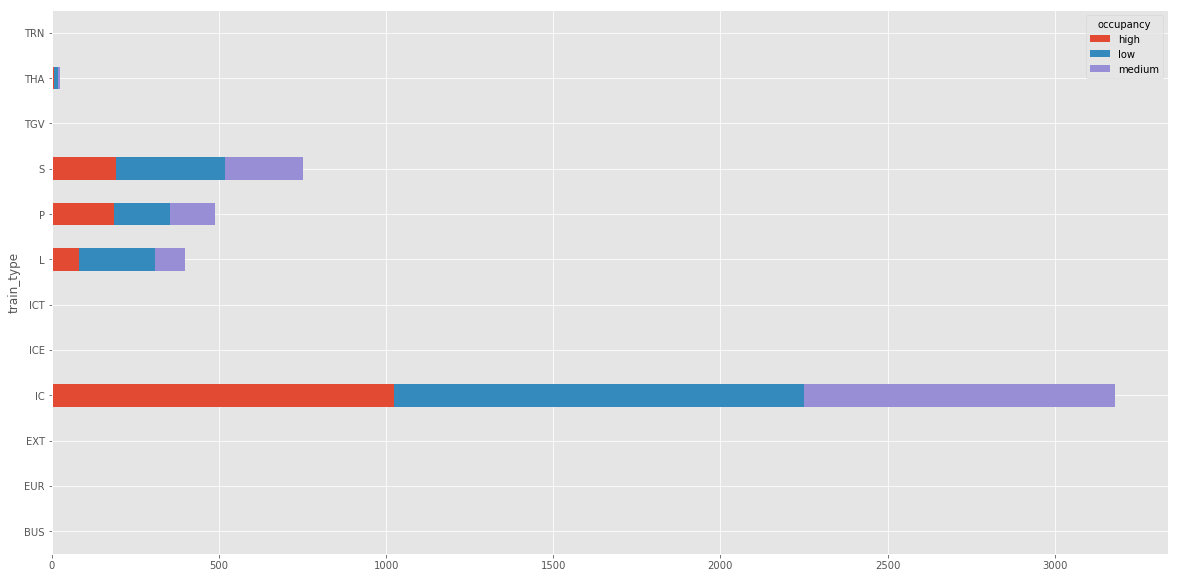

In [66]:
#1

piv1 = dataset.pivot_table(index='train_type', columns='occupancy', values='id', aggfunc='count').fillna(0)

fig, ax = plt.subplots(1,1, figsize=(20,10))

piv1.plot(kind='barh', stacked=True, ax=ax)

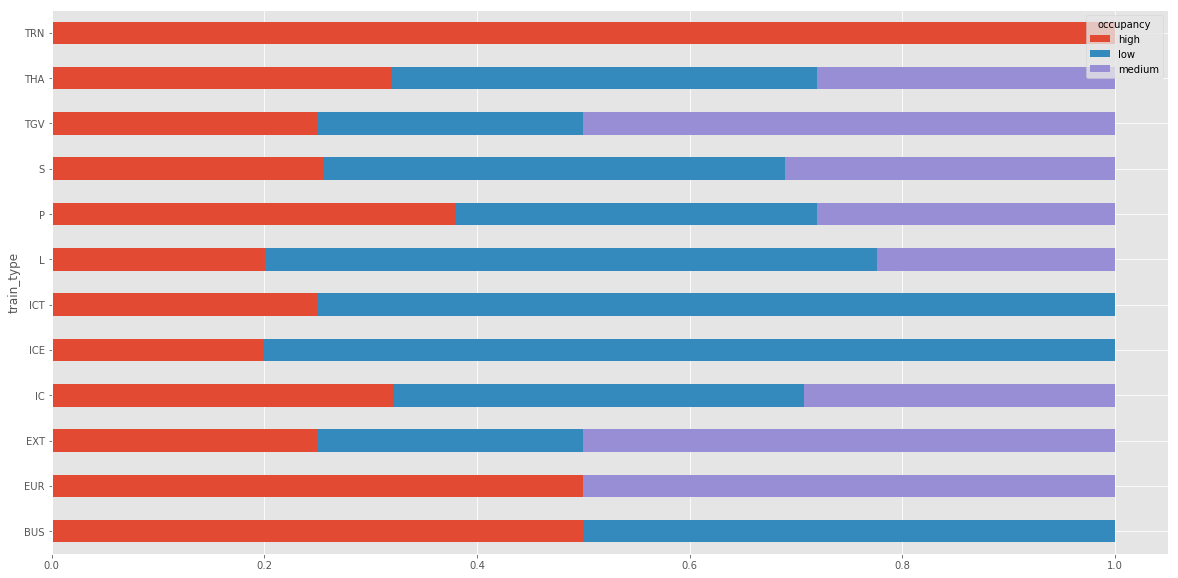

In [75]:
pivot_norm = (piv1.T / piv1.sum(axis=1)).T

fig, ax = plt.subplots(1,1, figsize=(20,10))

pivot_norm.plot(kind='barh', stacked=True, ax=ax)

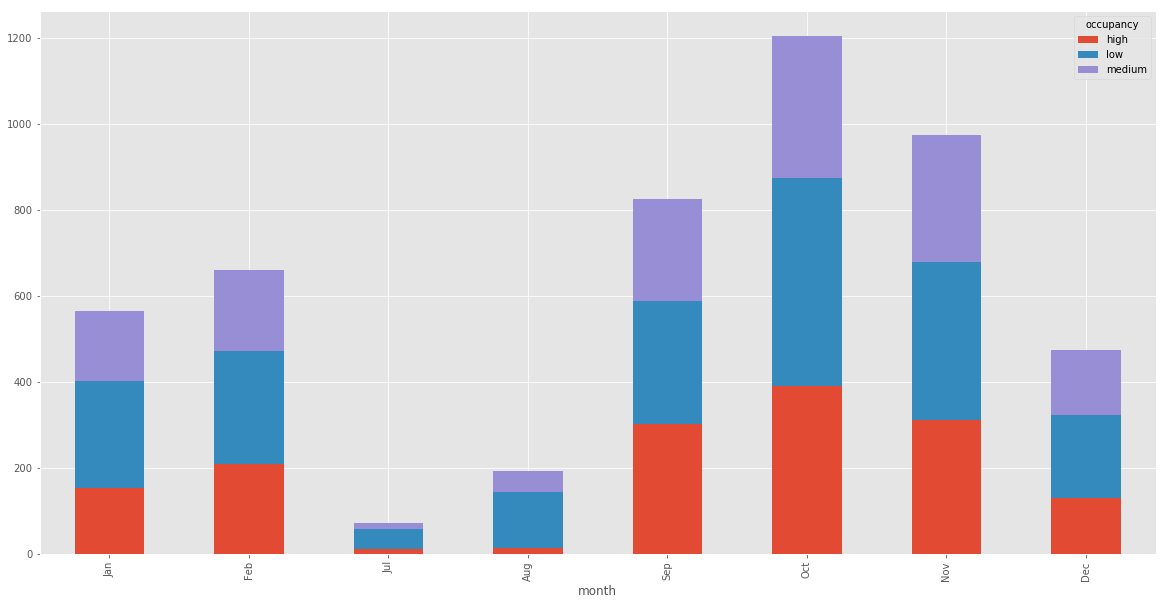

In [86]:
#2

dataset['month'] = dataset['querytime'].apply(lambda t: t.month)

piv2 = dataset.pivot_table(index='month', columns='occupancy', values='id', aggfunc='count').fillna(0)

fig, ax = plt.subplots(1,1, figsize=(20,10))

piv2.plot(kind='bar', stacked=True, ax=ax)

ax.set_xticklabels(['Jan', 'Feb', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

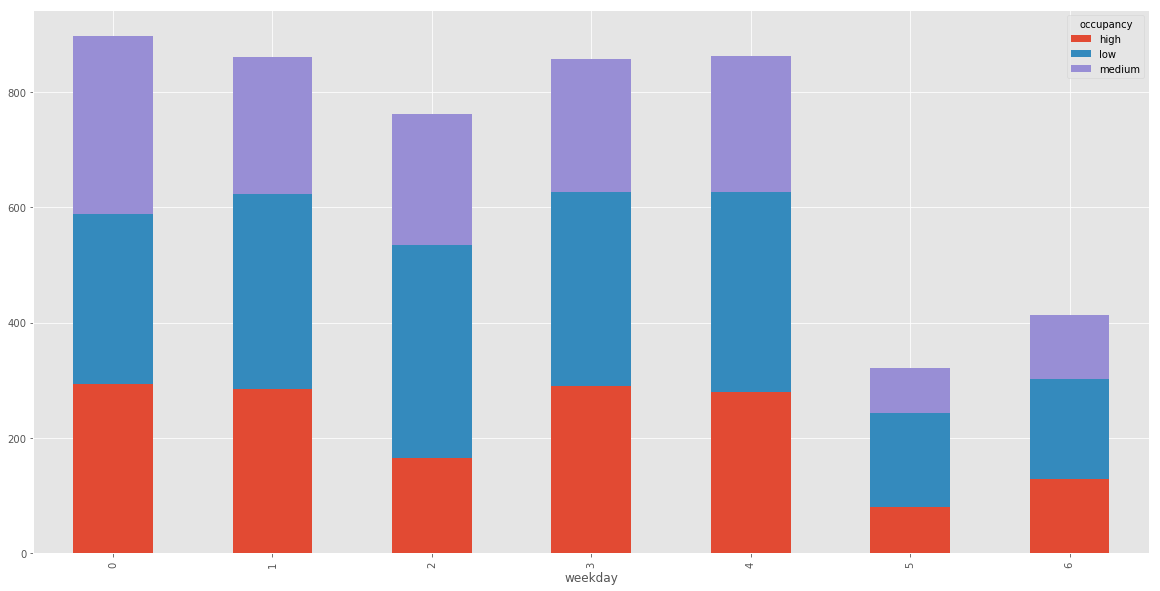

In [89]:
#3


piv3 = dataset.pivot_table(index='weekday', columns='occupancy', values='id', aggfunc='count').fillna(0)

fig, ax = plt.subplots(1,1, figsize=(20,10))

piv3.plot(kind='bar', stacked=True, ax=ax)

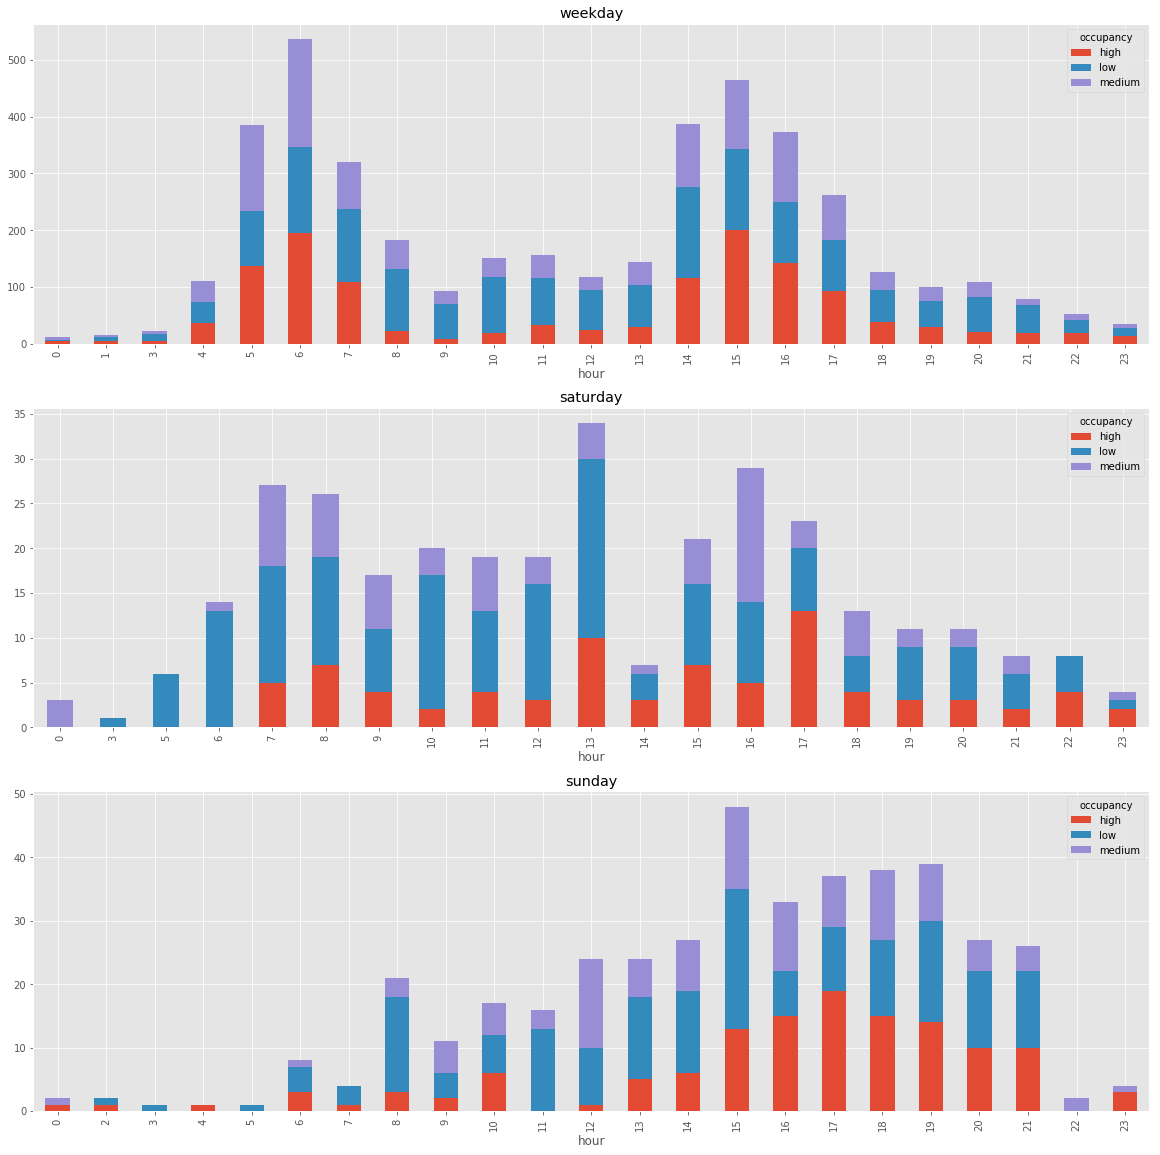

In [92]:
#4
#saturday
mask1= dataset['weekday'] < 5
mask2= dataset['weekday'] == 5
mask3= dataset['weekday'] == 6



fig, ax = plt.subplots(3,1, figsize=(20,20))

dataset[mask1].pivot_table(index='hour', columns='occupancy', values='id', aggfunc='count').fillna(0).plot(kind='bar', stacked=True, ax=ax[0], title='weekday')
dataset[mask2].pivot_table(index='hour', columns='occupancy', values='id', aggfunc='count').fillna(0).plot(kind='bar', stacked=True, ax=ax[1], title='saturday')
dataset[mask3].pivot_table(index='hour', columns='occupancy', values='id', aggfunc='count').fillna(0).plot(kind='bar', stacked=True, ax=ax[2], title='sunday')

## If you would build a simple rule-based model (hand-crafted rules) how would it look like?

## I would use features for...

* Sunday afternoon student rush
* Saturday 13h people go out
* weekday vs weekend
* rush hour (6-7 and 16-18h)
* Take into account holidays and school vacations (additional data), train is much more likely to have low occupancy
* Use train type as a feature: Local trains are more likely to have low occupancy
* Last but not least: a baseline predictor should always predict occupancy = Low => accuracy of 40%

